# Load the data 

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv(r"C:\Users\AzFar\Quora Duplicate Questions\data.csv")  
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Removing outliers by looking at std

In [5]:
from scipy import stats
import numpy as np

def remove_outliers(data):
     
        # X_train.ApplicantIncome.describe()
        upper_limit_income= data.ApplicantIncome.mean() + 3*data.ApplicantIncome.std()
        #print(upper_limit_income)
        lower_limit_income = data.ApplicantIncome.mean() - 3*data.ApplicantIncome.std()
        #print(lower_limit)
        data= data[(data['ApplicantIncome'] < upper_limit_income) & (data['ApplicantIncome']>lower_limit_income)]
        upper_limit_loan= data.LoanAmount.mean() + 3*data.LoanAmount.std()
        #print(upper_limit_loan)
        lower_limit_loan= data.LoanAmount.mean() - 3*data.LoanAmount.std()
        #print(lower_limit_loan) 
        data= data[(data['LoanAmount'] < upper_limit_loan) & (data['LoanAmount']>lower_limit_loan)]
        
        return data

        

# Splitting the dataset 

In [6]:
from sklearn.model_selection import train_test_split

df= remove_outliers(df)
X= df.drop(["Loan_Status","Loan_ID"], axis=1 )
y= df["Loan_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25) 

print(X_train.shape)
print(X_test.shape)

(456, 11)
(115, 11)


# Data Cleaning

This step typically involves imputing missing values and treating outliers.
Imputing Missing Values

Missing values may not always be NaNs. For instance, the Loan_Amount_Term might be 0, which does not make sense.


In [7]:
# Using pipeline to impute missing values

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV


In [8]:
col_cat= [col for col in X_train.columns if (X_train[col].dtypes=='object')]
num_col= [col for col in X_train.columns if (X_train[col].dtypes!='object')]


In [9]:
numeric_transform = Pipeline([('impute_num', SimpleImputer(strategy='most_frequent')), 
                              ('scaling', StandardScaler())])

categorical_transform = Pipeline([('impute_cat', SimpleImputer(strategy='constant',fill_value='unknown')), 
                                  ('one-hot-encode', OneHotEncoder(sparse=False))])

preprocessing = ColumnTransformer([('numeric', numeric_transform, ['LoanAmount', 'Loan_Amount_Term']),
                                        ('credit_hist_impute', SimpleImputer(strategy='constant', fill_value=0),['Credit_History']),
                                        ('categorical', categorical_transform, ['Gender','Married','Dependents','Self_Employed'])])


feature_union = FeatureUnion([('pca', PCA()), 
                              ('select_best', SelectKBest())])



In [10]:
X_train.shape

(456, 11)

# Modeling with LogisticRegression 

In [11]:
pipeline = Pipeline([('preprocessing', preprocessing), 
                          ('features', feature_union),
                          ('classifier', LogisticRegression())
                           #SVC())
                    ])

                           
# Find the best hyperparameters using GridSearchCV on the train set
param_grid = {#'classifier__alpha': [0.001, 0.01, 0.1], 
               #'classifier__kernel':['poly', 'rbf', 'sigmoid'],
               #'classifier__C': [50, 10, 1.0, 0.1, 0.01],
               #'classifier__gamma': ['scale'],
              'features__pca__n_components': [3, 5,7],
              'features__select_best__k': [5, 6, 8]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_hyperparams = grid.best_params_

best_acc = grid.score(X_test, y_test)
print(f'Best test set accuracy: {best_acc}\nAchieved with hyperparameters: {best_hyperparams}')


Best test set accuracy: 0.8347826086956521
Achieved with hyperparameters: {'features__pca__n_components': 3, 'features__select_best__k': 8}


# Deploy LogisticRegression Model in our disk 

In [12]:
import pickle

pickle.dump( grid, open( "LogisticRegression_model", "wb" ) )


# Using Pipeline

In [14]:
feature_union = FeatureUnion([('pca', PCA(n_components=3)), 
                              ('select_best', SelectKBest(k=8))])

pipeline = Pipeline([('preprocessing', preprocessing), 
                          ('features', feature_union),
                          ('classifier',LogisticRegression())])

pipeline.fit(X_train, y_train)

y_pred= pipeline.predict(X_test)


# Visulalizing the Pipeline

In [16]:
from sklearn import set_config
set_config(display='diagram')

pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['LoanAmount',
                                                   'Loan_Amount_Term']),
                                                 ('credit_hist_impute',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['Credit_History']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('one-hot-encode',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Gender', 'Married',
                                                   'Dependents',
                                                   'Self_Employed'])])),
                ('features',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=3)),
                                                ('select_best',
                                                 SelectKBest(k=8))])),
                ('classifier', LogisticRegression())])

# Confusion Matrix 

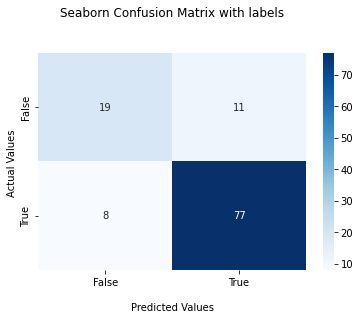

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()